# VAR

In [1]:
# To make realitve imports work
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# actual imports
from src.constants import YEARS, SEMESTERS
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

### Load All data into panda frames

In [2]:
from src.dataLoading import getStudents, getGraduates, getSallaries, getInflation
students = getStudents()
graduates = getGraduates()
sallaries = getSallaries()

### Prepare Data

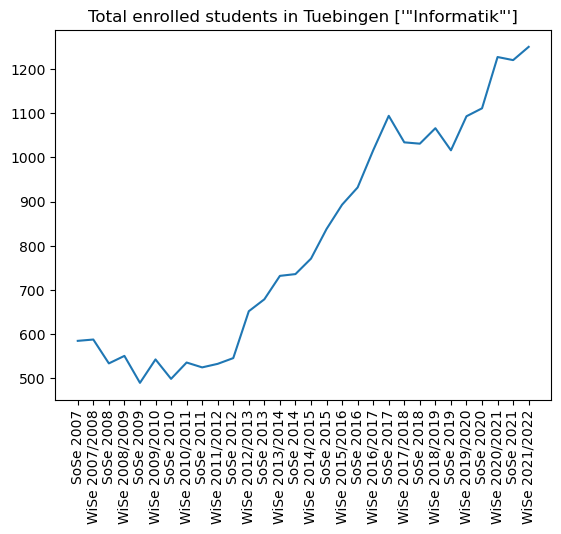

In [3]:
courses = students.index.levels[0].to_list() # if you use all optins, dont put that in the title down marked  there
courses = ['"Informatik"']

interestingYears = YEARS[3:-4]

studentsInCourseHF = np.empty((len(courses), 0))

for year in interestingYears:
    data_for_year = students.loc[(courses, 'HF'), (year, SEMESTERS)].to_numpy(dtype=int).sum(axis=1)
    data_for_year = data_for_year.reshape((len(courses), 1))
    studentsInCourseHF = np.hstack((studentsInCourseHF, data_for_year))

studentsInCourseNF = np.empty((len(courses), 0))

for year in interestingYears:
    data_for_year = students.loc[(courses, 'NF'), (year, SEMESTERS)].to_numpy(dtype=int).sum(axis=1)
    data_for_year = data_for_year.reshape((len(courses), 1))
    studentsInCourseNF = np.hstack((studentsInCourseNF, data_for_year))

totalStudents = studentsInCourseHF.sum(axis=0) + studentsInCourseNF.sum(axis=0)
plt.plot(interestingYears, totalStudents)
plt.xticks(rotation='vertical')
plt.title(f'Total enrolled students in Tuebingen {[course for course in courses]}') # here is there
plt.show()

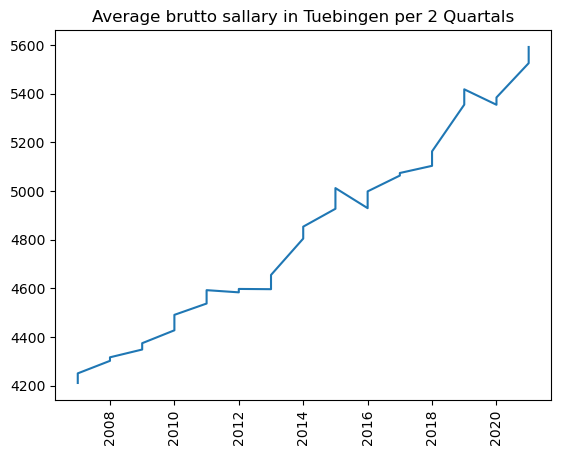

In [4]:
SECTOR = ('WZ08-62', 'Dienstleistungen der Informationstechnologie')
QUARTALS = ['1. Quartal', '2. Quartal', '3. Quartal', '4. Quartal']
SALLARY_YEARS = sallaries.index.levels[2]

bruttoSallary = sallaries.loc[(SECTOR[0], SECTOR[1], SALLARY_YEARS, QUARTALS), ('Insgesamt', 'Insgesamt', 'Durchschnittliche Bruttomonatsverdienste', 'EUR')].to_numpy(dtype=int)
bruttoSallary = bruttoSallary.reshape(-1, 2)
bruttoSallary = bruttoSallary.mean(axis=1)
plt.plot(SALLARY_YEARS.repeat(2), bruttoSallary)
plt.xticks(rotation='vertical')
plt.title('Average brutto sallary in Tuebingen per 2 Quartals')
plt.show()

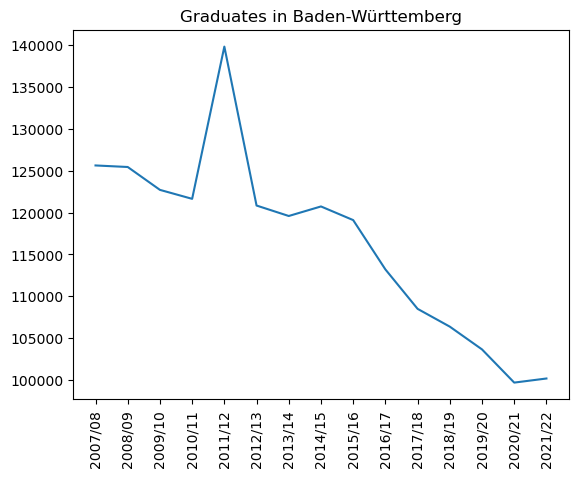

In [5]:
years = graduates.index.levels[1].to_list()
years = years[10:-1]
graduatesInBW = graduates.loc[('Insgesamt', years), ('Baden-Württemberg', 'Absolventen und Abgänger', 'Anzahl')].to_numpy()
graduatesInBW = np.where(graduatesInBW=='-', np.nan, graduatesInBW)
graduatesInBW = graduatesInBW.astype(float)
plt.plot(years, graduatesInBW)
plt.xticks(rotation='vertical')
plt.title('Graduates in Baden-Württemberg')
plt.show()

### Adjust brutto sallaries for inflation

In [6]:
inflation = getInflation()
inflation = inflation.loc[:,('Veränderungsrate zum Vorjahr', 'Prozent')].to_numpy(dtype=float)
inflation = inflation
cummulativeInflation = np.cumprod(1 + inflation / 100)
print('Create cummulative inflation:')
for a, b in zip(inflation, cummulativeInflation):
    print(f'{a} -> {b}')

print('\nAdjust sallary for inflation:')
bruttoInflationSallary = bruttoSallary / cummulativeInflation.repeat(2)
for a, b in zip(bruttoSallary, bruttoInflationSallary):
    print(f'{a} -> {b}')

Create cummulative inflation:
2.3 -> 1.023
2.8 -> 1.051644
0.2 -> 1.053747288
1.1 -> 1.065338508168
2.5 -> 1.0919719708722
2.2 -> 1.1159953542313885
1.6 -> 1.1338512798990907
0.8 -> 1.1429220901382835
0.7 -> 1.1509225447692513
0.4 -> 1.1555262349483282
1.7 -> 1.1751701809424497
1.9 -> 1.1974984143803562
1.4 -> 1.2142633921816812
0.4 -> 1.219120445750408
3.2 -> 1.258132300014421

Adjust sallary for inflation:
4211.5 -> 4116.813294232649
4251.0 -> 4155.4252199413495
4302.5 -> 4091.2133763897286
4317.0 -> 4105.001312231135
4349.0 -> 4127.175509276376
4375.0 -> 4151.8493568829945
4428.0 -> 4156.425367195795
4491.5 -> 4216.030834859963
4538.0 -> 4155.784325100693
4593.0 -> 4206.151918287238
4584.0 -> 4107.54398091299
4598.0 -> 4120.0888360030385
4597.0 -> 4054.323597367301
4655.5 -> 4105.9176653346685
4805.0 -> 4204.136083692842
4854.0 -> 4247.008647293455
4927.5 -> 4281.348056300275
5012.5 -> 4355.20185331408
4930.0 -> 4266.4544091640255
4999.0 -> 4326.1674627608445
5064.0 -> 4309.16311707

### Simple VAR-Modell for one subject, with data per semester

The data ranges from 2007 to (including) 2021.
Limited by the sallry data.

In [7]:
PAST_STEPS = 4
PREDICTION_STPES = 10
data = np.column_stack((totalStudents, bruttoInflationSallary, graduatesInBW.repeat(2)))

model = VAR(data)

results = model.fit(maxlags=PAST_STEPS)
# Forecasting
lagged_values = data[-PAST_STEPS:]  # Use the last available values as lagged values
forecast = results.forecast(lagged_values, steps=PREDICTION_STPES)
print(forecast)

[[  1244.35594206   4421.86012686 100032.38820635]
 [  1267.11051172   4489.5020666   97810.71084617]
 [  1282.54990751   4469.45661276  93216.87989628]
 [  1322.08607372   4497.56056557  94301.12127162]
 [  1338.68793576   4487.50095367  93952.86032028]
 [  1354.76106521   4508.10975628  94014.55355316]
 [  1364.9097212    4515.7166047   93747.16906161]
 [  1375.58328606   4526.38962953  92723.24640122]
 [  1392.90466323   4529.71687778  90978.82499589]
 [  1409.25665333   4533.96712586  90077.767634  ]]


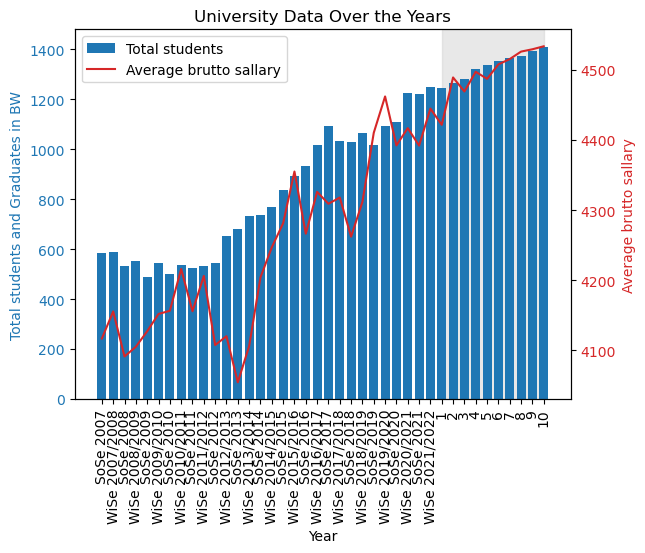

In [8]:
dataWithForecast = np.vstack((data, forecast))
yearsWithForecast = np.append(interestingYears, [f"{i+1}" for i in range(PREDICTION_STPES)])

fig, ax1 = plt.subplots()
plt.title('University Data Over the Years')
plt.xticks(rotation='vertical')
plt.axvspan(len(data), len(dataWithForecast) - 1, alpha=0.5, color='lightgrey')

ax1.set_xlabel('Year')
ax1.set_ylabel('Total students and Graduates in BW', color='tab:blue')
ax1.bar(yearsWithForecast, dataWithForecast[:, 0], color='tab:blue', label='Total students')  # Changed to bar
ax1.tick_params(axis='y', labelcolor='tab:blue')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Average brutto sallary', color=color)  # we already handled the x-label with ax1
ax2.plot(yearsWithForecast, dataWithForecast[:, 1], color=color, label='Average brutto sallary')
ax2.tick_params(axis='y', labelcolor=color)

# Create one legend for both subplots
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()